# Historical Years

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a historical 3 day period.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import warnings
import pandas as pd
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2016-12-01 00:00:00'
end = '2016-12-03 23:30:00'
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [4]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='historical', merge_generators=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invali

In [5]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

INFO:pypsa.networks:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, loads, storage_units


To approximate n-1 security and allow room for reactive power flows, don't allow any line to be loaded above 70% of their thermal rating

In [6]:
contingency_factor = 0.7
network.lines.s_max_pu[0:99] *= contingency_factor

## Running the optimisation

In [7]:
network.optimize(network.snapshots, solver_name="highs")

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '95', '96', '97', '98', '99', '100', '101', '102', '103', '104'],
      dtype='object', name='Line', length=105)
Index(['16', '99', '100', '101', '102', '103', '104'], dtype='object', name='Line')
Index(['Drax - coal units', 'Ratcliffe', 'Cottam', 'West Burton', 'Eggborough',
       'Rugeley', 'Aberthaw B', 'Fiddler`s Ferry', 'Dungeness B', 'Hartlepool',
       ...
       'Small Hydro Stella West', 'Small Hydro Neilston', 'Small Hydro Beauly',
       'Small Hydro Denny/Bonnybridge', 'Small Hydro Errochty',
       'Interconnector Deeside', 'Interconnector Sellindge',
       'Interconnector Neilston', 'Interconnector Kemsley',
       'Interconnector Lovedean'],
      dtype='object', name='Generator', length=657)
Index(['Dinorwig', 'Ffestiniog', 'Cruachan', 'Foyers'], dtype='object', name='StorageUnit')
Index(['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston',
       'Strathaven', 'Torness', 'Eccle

('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [8]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

carrier,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),Coal,EfW Incineration,Interconnectors Import,Landfill Gas,Hydro,Natural Gas,Nuclear,Oil,Sewage Sludge Digestion,Shoreline Wave,Small Hydro,Solar Photovoltaics,Wind Offshore,Wind Onshore,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,
2016-12-01 00:00:00,244.200001,0.00,0.000000,0.000000,356.436,1225.000030,743.500001,123.564542,18434.173870,6510.14,0.0,44.4,23.0,14.435458,0.0,2029.771917,3943.378169,740.000000,1032.100002
2016-12-01 01:00:00,244.200001,0.00,0.000000,0.000000,356.436,1297.000044,743.500001,112.819800,18676.036879,6510.14,0.0,44.4,23.0,13.180201,0.0,2137.095635,4128.599503,498.592301,1032.100002
2016-12-01 02:00:00,244.200001,0.00,0.000000,0.000000,356.436,1297.500042,743.500001,95.807290,18654.904276,6510.14,0.0,44.4,23.0,11.192710,0.0,2119.227793,4354.619356,238.572589,1032.100002
2016-12-01 03:00:00,244.200001,0.00,0.000000,0.000000,356.436,1296.500039,743.500001,94.911895,17982.174155,6510.14,0.0,44.4,23.0,11.088105,0.0,2105.413336,4297.966632,228.770206,1032.100002
2016-12-01 04:00:00,244.200001,0.00,0.000000,0.000000,356.436,1297.000034,743.500001,90.434919,17484.266995,6510.14,0.0,44.4,24.0,10.565081,0.0,2066.067050,4400.695404,107.294465,1032.100002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-03 19:00:00,244.200001,509.54,1026.380001,302.486999,356.436,1973.000066,743.500001,421.731155,29827.448915,6510.14,0.0,44.4,24.0,49.268845,0.0,1796.253466,780.214217,0.000000,2568.020002
2016-12-03 20:00:00,244.200001,38.69,713.403937,0.000000,356.436,1127.499994,743.500001,291.003451,29859.334040,6510.14,0.0,44.4,24.0,33.996549,0.0,1850.403789,809.992467,0.000000,1784.193939
2016-12-03 21:00:00,244.200001,0.00,0.000000,0.000000,356.436,1670.000052,743.500001,223.401111,27157.598030,6510.14,0.0,44.4,24.0,26.098889,0.0,1890.424424,866.909286,121.392052,1032.100002


Graph the power output of the different generation types...

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



Text(0.5, 0, '')

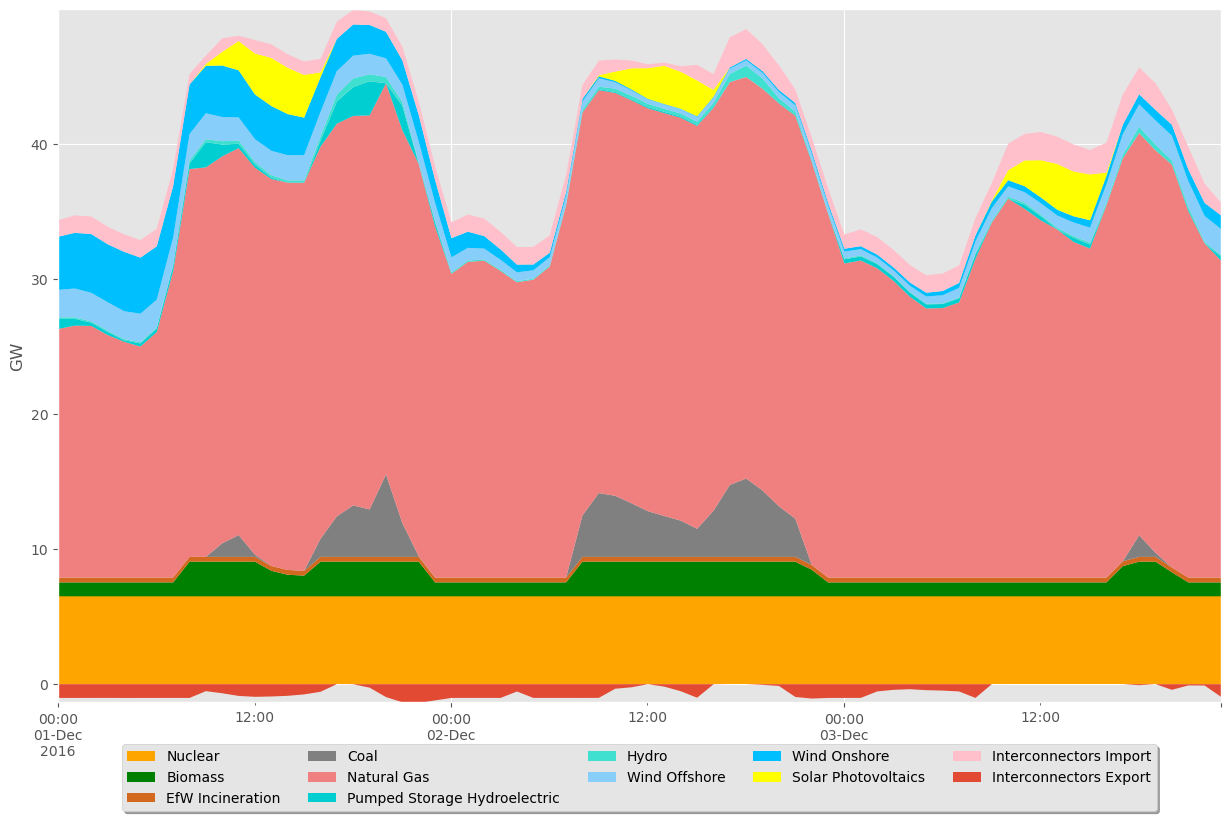

In [9]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration',
        "Coal", "Oil", "Natural Gas",
        "Pumped Storage Hydroelectric", 'Hydro',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

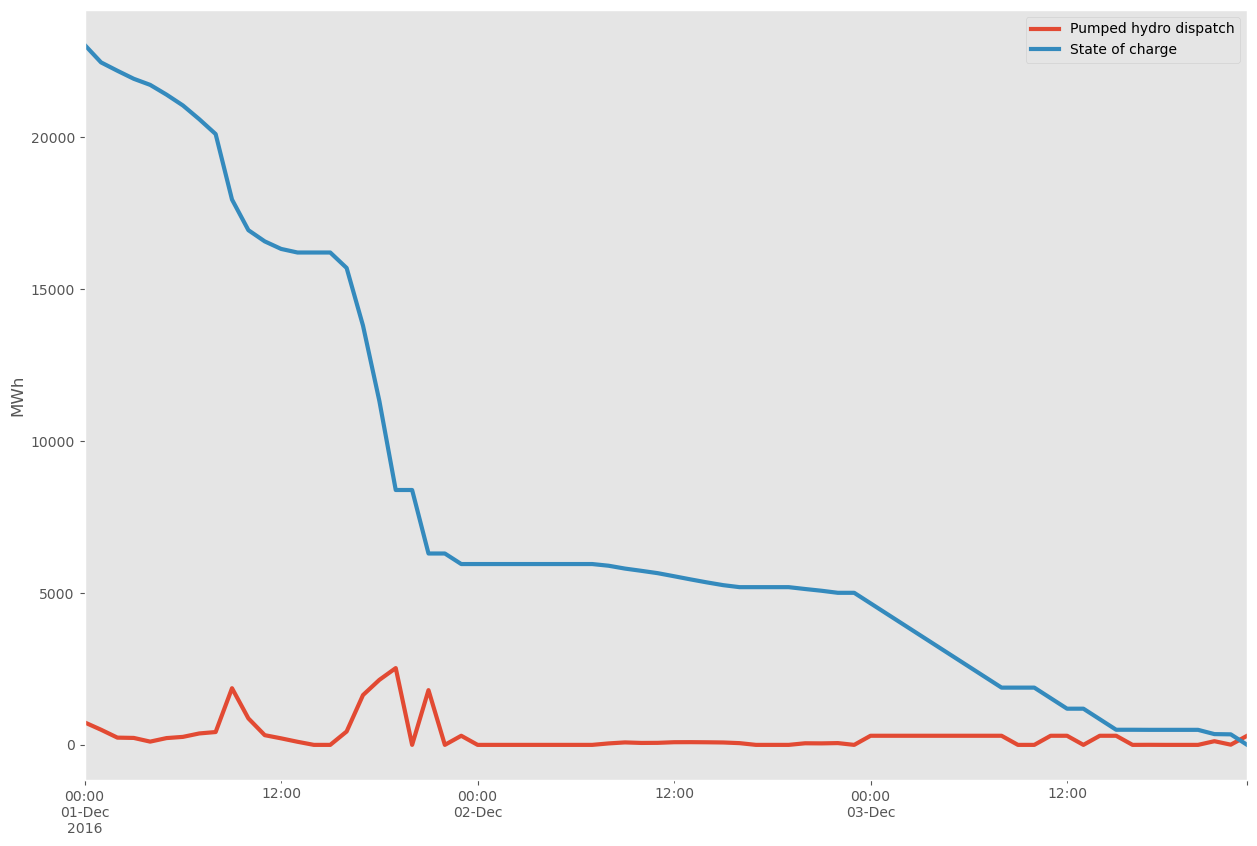

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [11]:
now = network.snapshots[60]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    105.000000
mean      -0.016344
std        0.196331
min       -0.653502
25%       -0.098152
50%        0.000000
75%        0.060394
max        0.700000
dtype: float64

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x1d813a6b2c0>,
 <matplotlib.collections.LineCollection at 0x1d813c27050>)

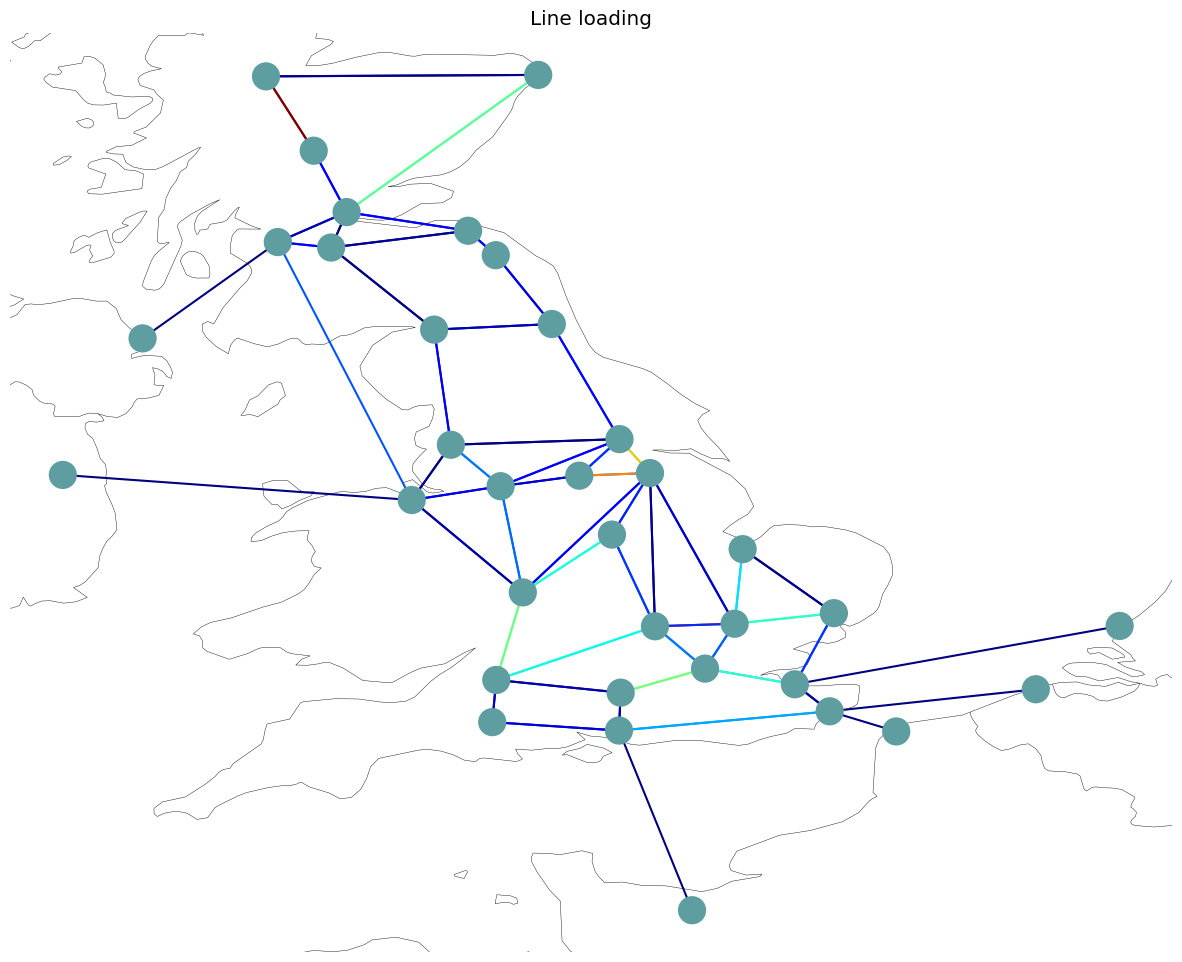

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



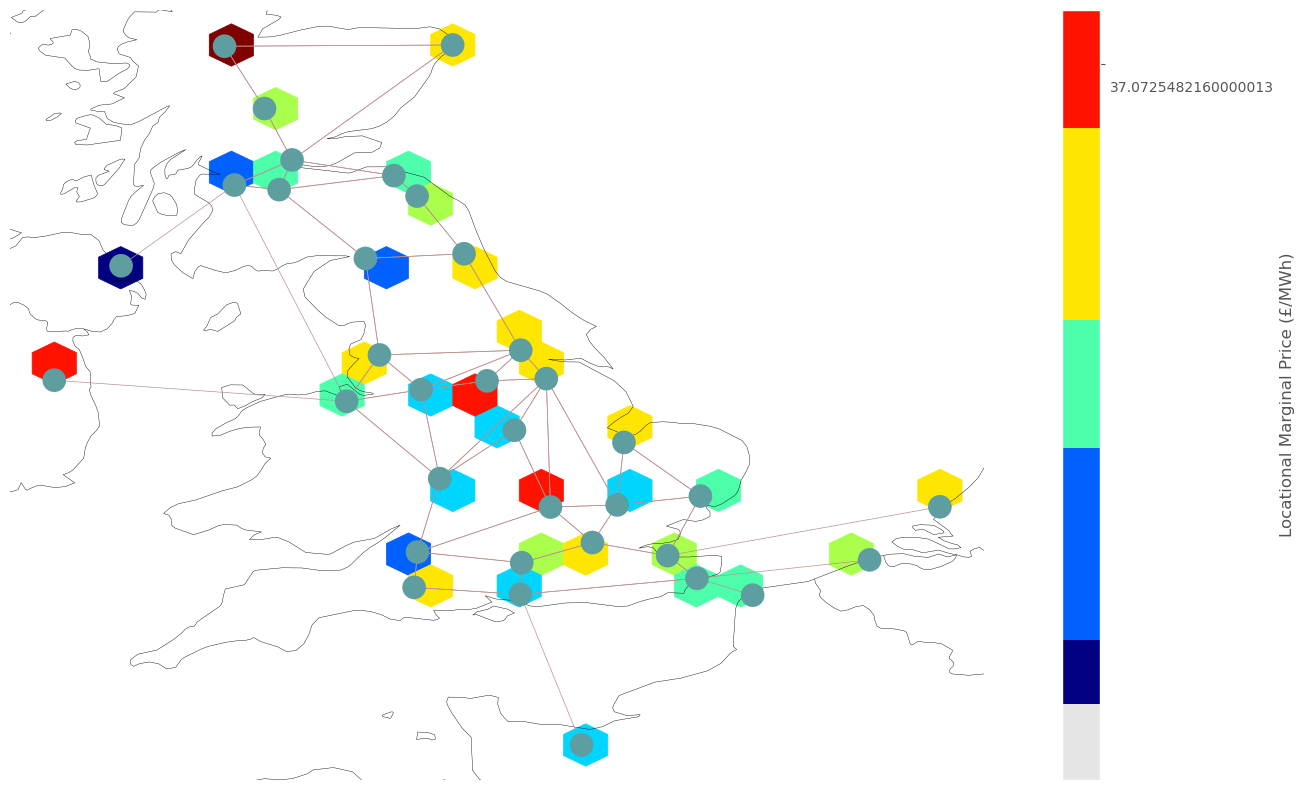

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

## Plotting curtailment

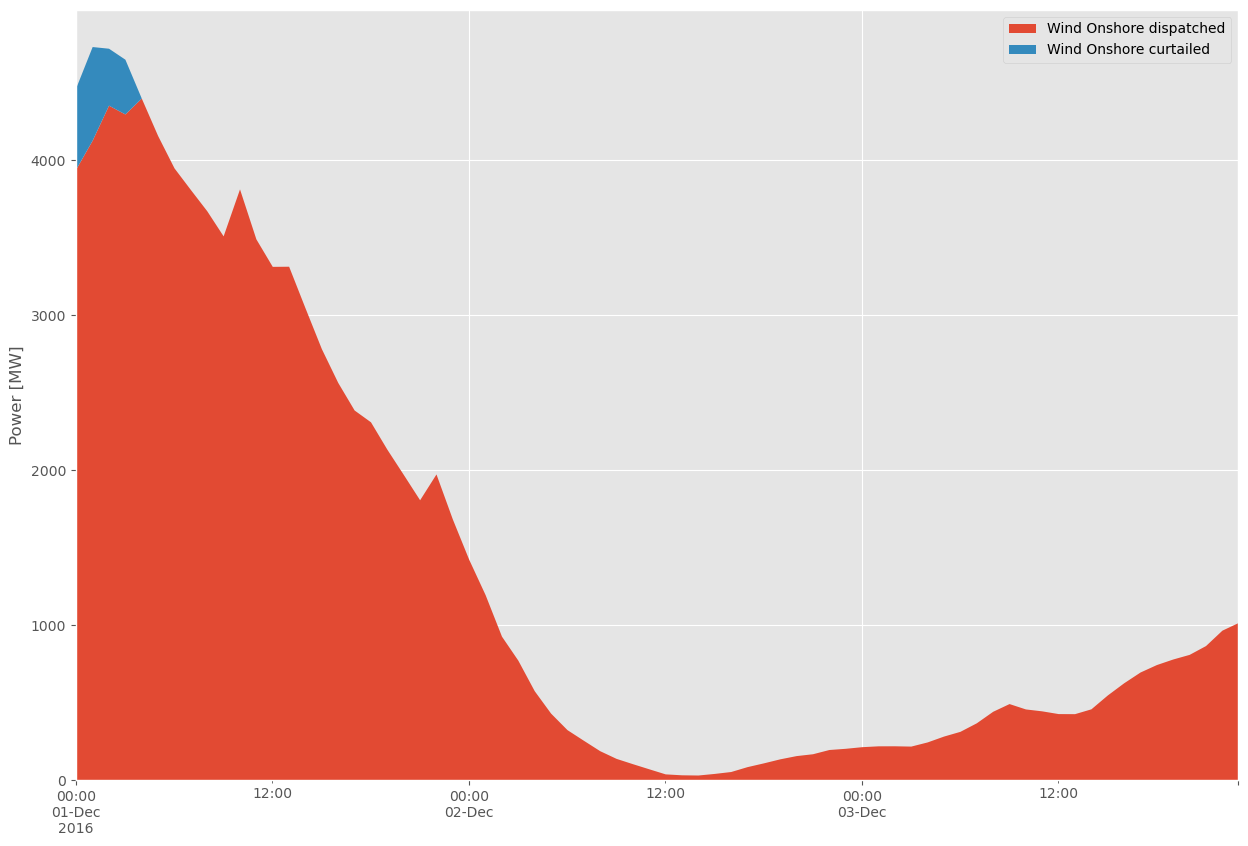

In [14]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()